In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Tuple


from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from scipy.stats import randint

In [2]:
products_df = pd.read_csv('./data/feature_frame.csv')

In [3]:
def get_relevant_orders_df(df: pd.DataFrame, num_orders: int) -> pd.DataFrame:
    """We get the orders that have more or equal than num_orders products bought"""
    bought_products = df.query('outcome == 1')
    orders_relevants = bought_products.groupby('order_id')['variant_id'].agg(lambda x: len(list(x))).reset_index().query(f'variant_id >= {num_orders}')
    return df.merge(orders_relevants[['order_id']], on='order_id')

In [4]:
filtered_df = get_relevant_orders_df(products_df, 5)

In [5]:
print(f"Original number of orders: {products_df['order_id'].nunique()}")
print(f"Orders bigger or equal than 5: {filtered_df['order_id'].nunique()}")

Original number of orders: 3446
Orders bigger or equal than 5: 2603


In [6]:
filtered_df['order_date'] = pd.to_datetime(filtered_df['order_date']).dt.date
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])

In [7]:
info_cols = ['variant_id','order_id','user_id',"created_at","order_date"]

count_cols = ['count_adults', 'count_children',
       'count_babies', 'count_pets', 'people_ex_baby']

categorical_cols = ['vendor', 'product_type']

label_col = 'outcome'

feature_cols = [col for col in filtered_df.columns if col not in info_cols+count_cols+categorical_cols+[label_col]]

In [8]:
filtered_df[categorical_cols].nunique()

vendor          264
product_type     62
dtype: int64

- Id and date columns are not used for the prediction, so we drop them.
- Count columns are unreliable since the majority of the data were non-existent and were imputed with the mean as we saw at the EDA. We drop them.
- Categorical cols are not used in the model, due to the amount of cardinality. We drop them.

In [58]:
X = filtered_df.drop(['outcome']+info_cols+categorical_cols+count_cols, axis=1)
Y = filtered_df['outcome']

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163953 entries, 0 to 2163952
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_order_seq                    int64  
 1   ordered_before                    float64
 2   abandoned_before                  float64
 3   active_snoozed                    float64
 4   set_as_regular                    float64
 5   normalised_price                  float64
 6   discount_pct                      float64
 7   global_popularity                 float64
 8   days_since_purchase_variant_id    float64
 9   avg_days_to_buy_variant_id        float64
 10  std_days_to_buy_variant_id        float64
 11  days_since_purchase_product_type  float64
 12  avg_days_to_buy_product_type      float64
 13  std_days_to_buy_product_type      float64
dtypes: float64(13), int64(1)
memory usage: 231.1 MB


In [11]:
X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, test_size=0.7, random_state=15,shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, test_size=0.5, random_state=15,shuffle=False)

In [12]:
def plot_roc__pr_curves(model_name:str,y_pred: pd.Series,y_test:pd.Series, 
                        figure = None):
     
    precision,recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

      
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig,ax = figure
        
        
    ax[0].plot(recall, precision, label=f"{model_name} AUC: {pr_auc:.3f}")
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    
    ax[1].plot(fpr, tpr, label=f"{model_name} AUC: {roc_auc:.3f}")
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC curve')
    ax[1].legend()

In [13]:
def plot_feature_importances(importances:list[int],features:list[str])->None:
    df_importances = pd.DataFrame({'feature': features, 'importance':importances}).sort_values(by='importance', ascending=False)
    sns.barplot(data=df_importances,x='importance',y='feature')
    plt.title('Feature Importances')

In [14]:
def time_model(model: Pipeline, X:pd.DataFrame, Y:pd.Series)->Tuple[float,float]:
    """We get the time it takes to train and predict the model"""
    start_time_train = time.time()
    model.fit(X, Y)
    end_time_train = time.time()
    train_time = end_time_train - start_time_train
    
    start_time_pred = time.time()
    model.predict_proba(X)[:,1]
    end_time_pred = time.time()
    pred_time = end_time_pred - start_time_pred
    return train_time, pred_time

## Baseline

We will use the performance obtained by the LogisticRegression model we trained in the previous notebook as the baseline

In [15]:
log_l1 = Pipeline([('scaler', StandardScaler()),
                    ('estimator', LogisticRegression(solver='liblinear',
                                                    penalty='l1',
                                                    C=0.001))])
log_l1.fit(X_train,Y_train)


log_l2 = Pipeline([('scaler', StandardScaler()),
                    ('estimator', LogisticRegression(solver='liblinear',
                                                    penalty='l2',
                                                    C=0.001))])
log_l2.fit(X_train,Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=0.001, solver='liblinear'))])

## Random Forest

In [52]:
rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier())
])

param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__max_depth': randint(5, 20),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='average_precision',  
    cv=tscv,
    n_jobs=-1, 
    random_state=15
)

random_search_rf.fit(X_train, Y_train)

print("Best parameters:", random_search_rf.best_params_)
print("Best cross-validation score:", random_search_rf.best_score_)

Best parameters: {'estimator__max_depth': 13, 'estimator__min_samples_leaf': 9, 'estimator__min_samples_split': 6, 'estimator__n_estimators': 149}
Best cross-validation score: 0.1859672882683429


In [16]:
best_params_rf = {'max_depth': 13, 'min_samples_leaf': 9, 
               'min_samples_split': 6, 'n_estimators': 149}

In [17]:
best_rf_model = Pipeline([('scaler', StandardScaler()),
                    ('estimator', RandomForestClassifier(**best_params_rf))])
best_rf_model.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=13, min_samples_leaf=9,
                                        min_samples_split=6,
                                        n_estimators=149))])

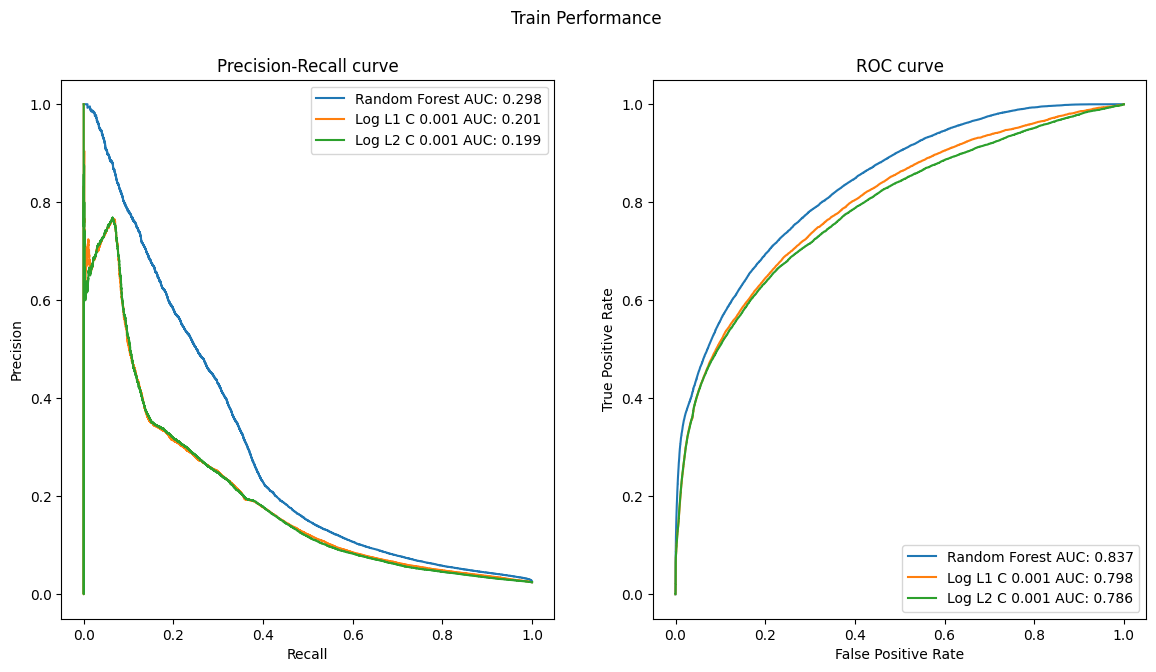

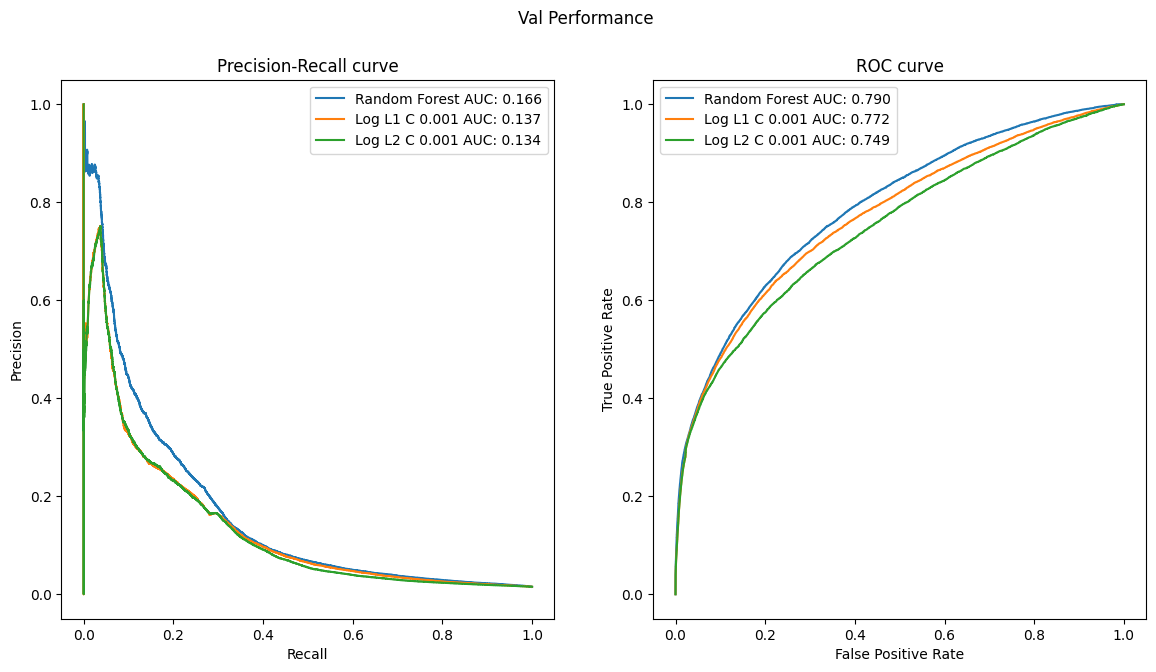

In [18]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Train Performance')
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle('Val Performance')


plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Log L2 C 0.001',log_l2.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))

plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Log L2 C 0.001',log_l2.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))

**Insights**
- We can see that Random Forest outperforms by far the Logistic Regression models used as baseline, both in the training and validation set, for the chosen metrics

### Feature Selection

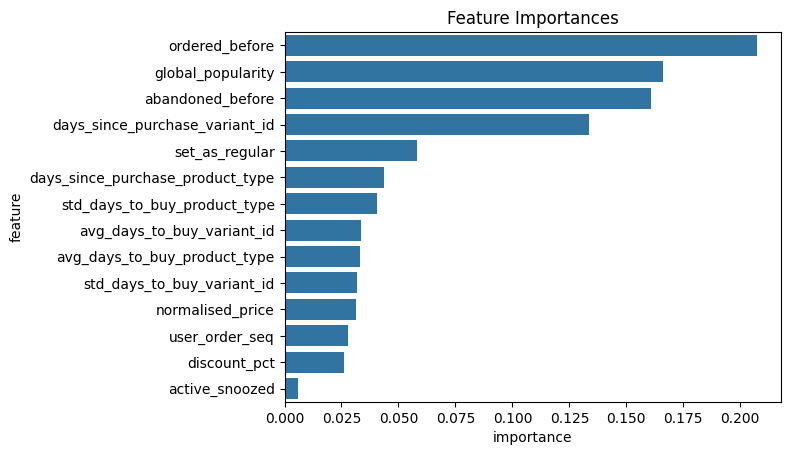

In [19]:
plot_feature_importances(best_rf_model.named_steps['estimator'].feature_importances_,X_train.columns)

In [21]:
new_features_rf = ['abandoned_before','ordered_before','global_popularity','days_since_purchase_variant_id']
new_features_rf

['abandoned_before',
 'ordered_before',
 'global_popularity',
 'days_since_purchase_variant_id']

In [22]:
rf_model_reduced = Pipeline([('scaler', StandardScaler()),
                    ('estimator', RandomForestClassifier(**best_params_rf))])
rf_model_reduced.fit(X_train.loc[:,X.columns.isin(new_features_rf)],Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=13, min_samples_leaf=9,
                                        min_samples_split=6,
                                        n_estimators=149))])

In [22]:
time_rf_train,time_rf_pred = time_model(best_rf_model, X_train, Y_train)
time_rfre_train, time_rfre_pred = time_model(rf_model_reduced, X_train.loc[:,X.columns.isin(new_features_rf)], Y_train)

In [23]:
print(f"Random Forest (original) - Time to train: {time_rf_train:.4f} seconds")
print(f"Random Forest (original) - Time to predict: {time_rf_pred:.4f} seconds")
print(f"Random Forest (reduced features) - Time to train: {time_rfre_train:.4f} seconds")
print(f"Random Forest (reduced features) - Time to predict: {time_rfre_pred:.4f} seconds")

Random Forest (original) - Time to train: 57.1273 seconds
Random Forest (original) - Time to predict: 4.5060 seconds
Random Forest (reduced features) - Time to train: 80.3164 seconds
Random Forest (reduced features) - Time to predict: 4.1850 seconds


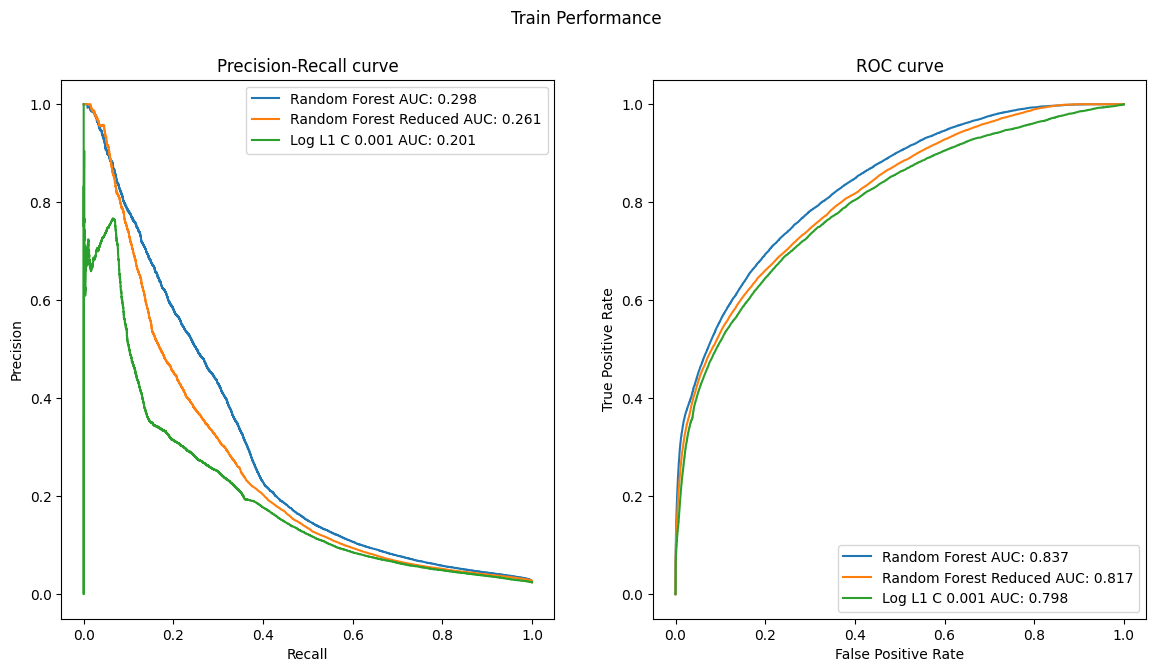

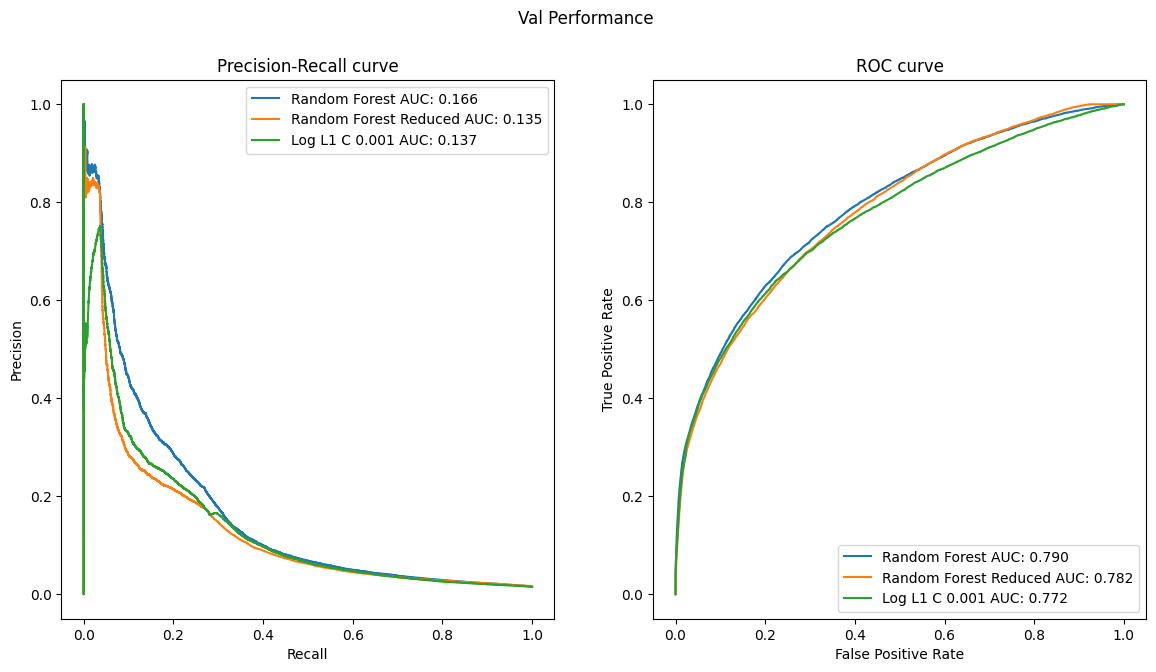

In [23]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Train Performance')
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle('Val Performance')


plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Random Forest Reduced',rf_model_reduced.predict_proba(X_train.loc[:,X.columns.isin(new_features_rf)])[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))


plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Random Forest Reduced',rf_model_reduced.predict_proba(X_val.loc[:,X.columns.isin(new_features_rf)])[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))

**Insights**
- Random Forest with reduced features performs worse than the model with all features, but still outperforms the logistic regression models used as baseline, both in the training and validation set, for the Precision-Recall Curve and is very close in the ROC Curve
- The model with reduced variables is faster to train and predict, however, being models that do not cost much time to train and the difference is not big, it is not worth the time-performance trade-off, so we will choose the model with all features to continue the analysis.

## Gradient Boosting

In [ ]:
gbc = Pipeline([('scaler', StandardScaler()),
                    ('estimator', GradientBoostingClassifier())])

param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__max_depth': randint(5, 20),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 10)
}

# Configure RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) 

random_search_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='average_precision',  
    cv=tscv,
    n_jobs=-1, 
    random_state=15
)

random_search_gbc.fit(X_train, Y_train)

print("Best parameters:", random_search_gbc.best_params_)
print("Best cross-validation score:", random_search_gbc.best_score_)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CAAECF2DD0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CAAED20050>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CAAECF3810>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CAAED0EA90>},
                   random_state=15, scoring='average_precision')

In [27]:
best_gbc_params = {'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 125}

In [26]:
best_gbc_model = Pipeline([('scaler', StandardScaler()),
                    ('estimator', GradientBoostingClassifier(**best_gbc_params))])
best_gbc_model.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 GradientBoostingClassifier(max_depth=5, min_samples_leaf=6,
                                            min_samples_split=4,
                                            n_estimators=125))])

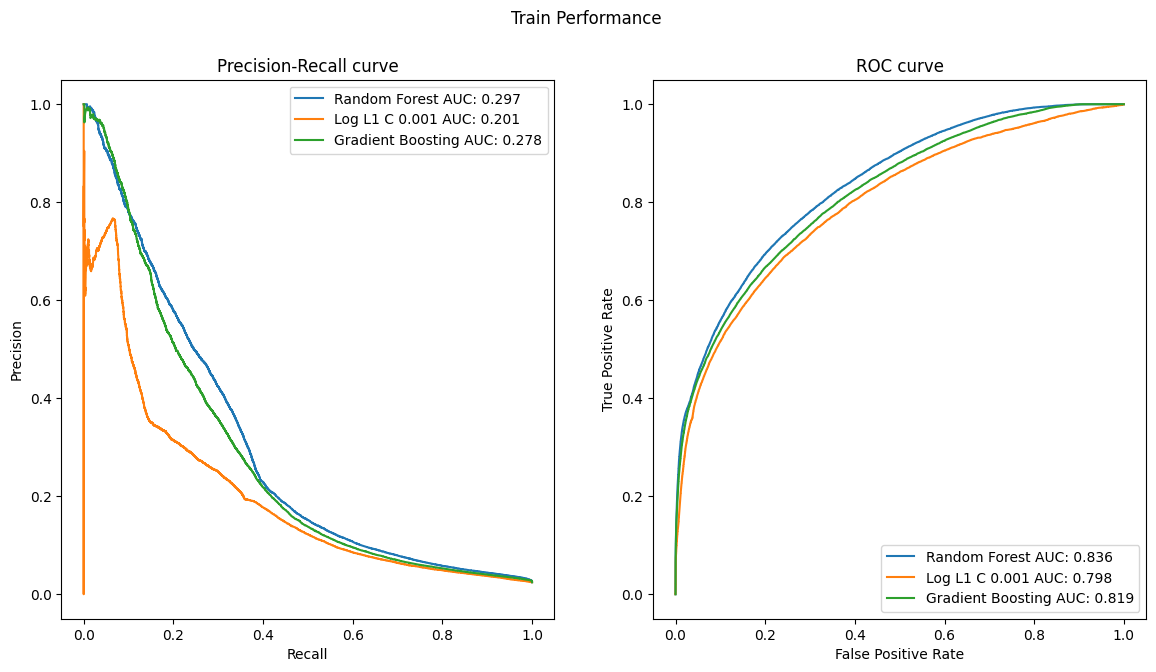

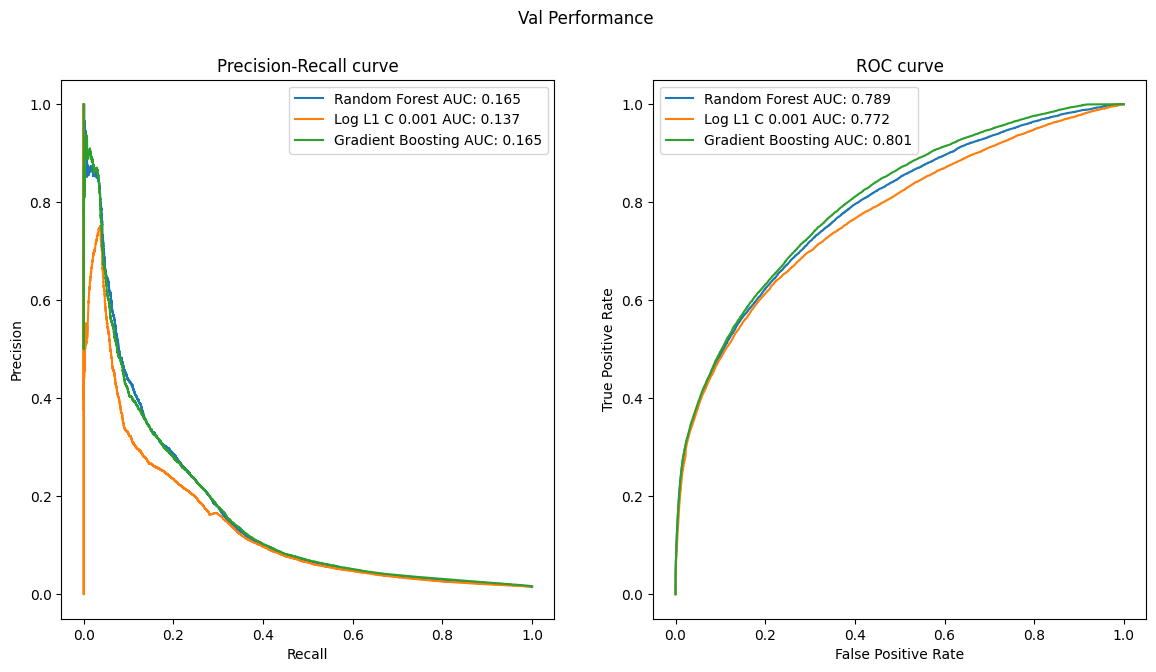

In [27]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Train Performance')
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle('Val Performance')


plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Gradient Boosting',best_gbc_model.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))

plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Gradient Boosting',best_gbc_model.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))

**Insights:**
- Gradient Boosting model outperforms the Logistic Regression model used as baseline, both in the training and validation set, for the chosen metrics.
- However, the Random Forest model outperforms the Gradient Boosting model.
- We will try to improve the Gradient Boosting model with feature selection.


### Feature Selection

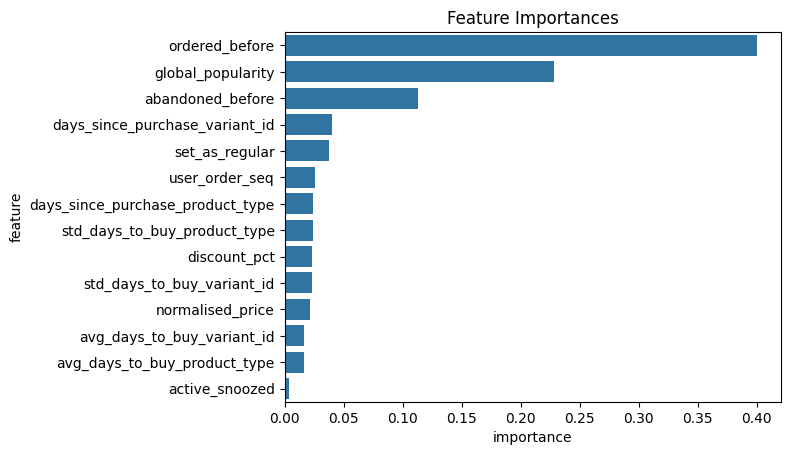

In [28]:
plot_feature_importances(best_gbc_model.named_steps['estimator'].feature_importances_,X.columns)

In [28]:
new_features_gbc = ['abandoned_before','ordered_before','global_popularity']

In [29]:
gbc_model_reduced = Pipeline([('scaler', StandardScaler()),
                    ('estimator', GradientBoostingClassifier(**best_gbc_params))])
gbc_model_reduced.fit(X_train.loc[:,X.columns.isin(new_features_gbc)],Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 GradientBoostingClassifier(max_depth=5, min_samples_leaf=6,
                                            min_samples_split=4,
                                            n_estimators=125))])

In [31]:
time_gbc_train,time_gbc_pred = time_model(best_gbc_model, X_train, Y_train)
time_gbc_re_train,time_gbc_re_pred = time_model(gbc_model_reduced, X_train.loc[:,X.columns.isin(new_features_gbc)], Y_train)

In [32]:
print(f"Gradient Boosting (original) - Time to train: {time_gbc_train:.4f} seconds")
print(f"Gradient Boosting (original) - Time to predict: {time_gbc_pred:.4f} seconds")
print(f"Gradient Boosting (reduced features) - Time to train: {time_gbc_re_train:.4f} seconds")
print(f"Gradient Boosting (reduced features) - Time to predict: {time_gbc_re_pred:.4f} seconds")

Gradient Boosting (original) - Time to train: 118.2540 seconds
Gradient Boosting (original) - Time to predict: 1.0430 seconds
Gradient Boosting (reduced features) - Time to train: 50.7791 seconds
Gradient Boosting (reduced features) - Time to predict: 0.7210 seconds


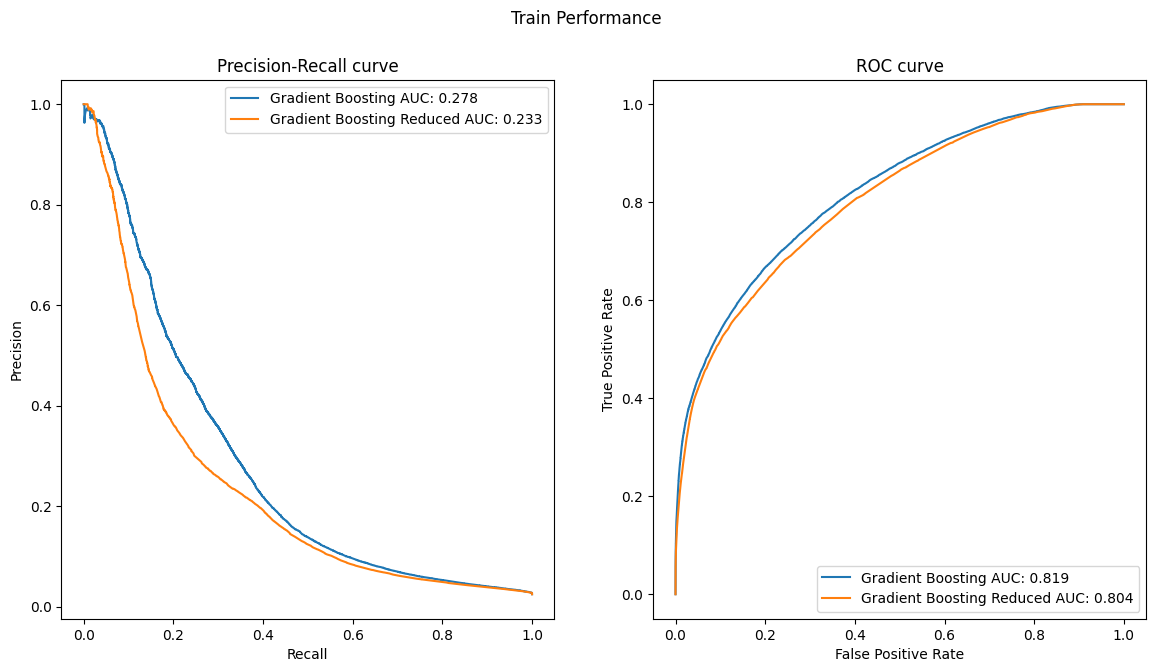

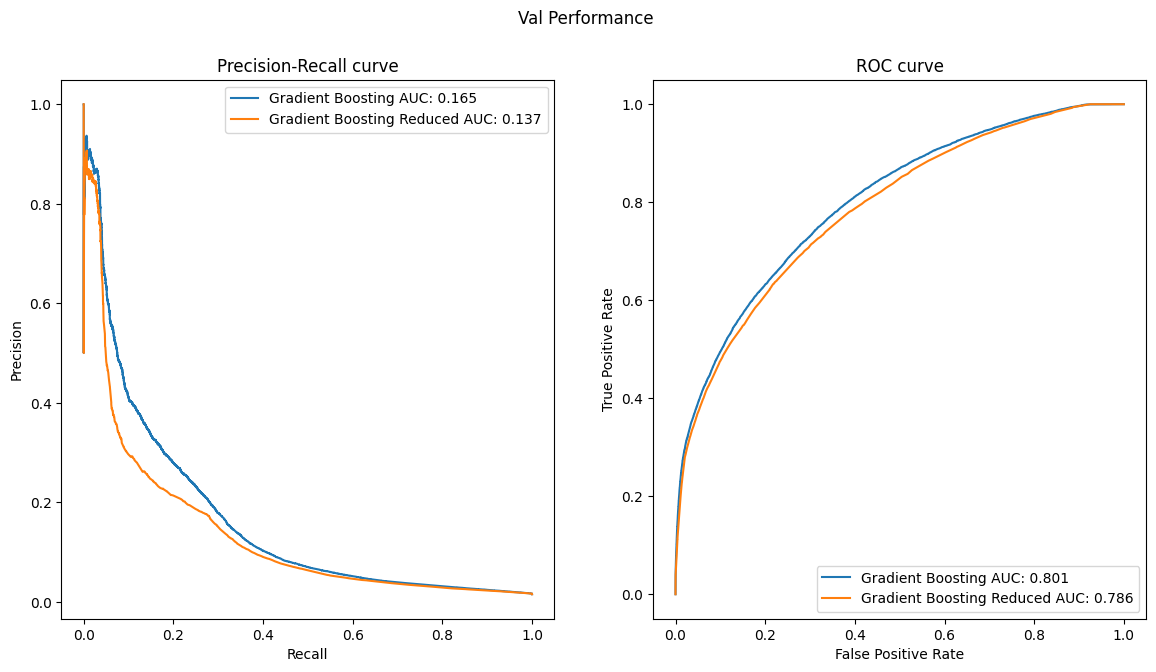

In [33]:
fig1,ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Train Performance')
fig2,ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle('Val Performance')

plot_roc__pr_curves('Gradient Boosting',best_gbc_model.predict_proba(X_train)[:,1],
                    Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Gradient Boosting Reduced',gbc_model_reduced.predict_proba(X_train.loc[:,X.columns.isin(new_features_gbc)])[:,1],
                    Y_train,figure=(fig1,ax1))

plot_roc__pr_curves('Gradient Boosting',best_gbc_model.predict_proba(X_val)[:,1],
                    Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Gradient Boosting Reduced',gbc_model_reduced.predict_proba(X_val.loc[:,X.columns.isin(new_features_gbc)])[:,1],
                    Y_val,figure=(fig2,ax2))

**Insights:**
- In the test set, Gradient Boosting model with reduced features performs worse than the model with all features.
- In the validation set the reduced model achieves better results in the Precision-Recall Curve and practically the same at the ROC Curve.
- These can be due to the fact the reduced model is less prone to overfit and maybe the features we dropped were generating noise and worsing the model capacity to generalize.
- With these insights, we will use the reduced model for the Gradient Boosting model. 

## Baseline vs Random Forest vs Gradient Boosting

To compare the models chosen, we will use the Precision-Recall Curve and ROC Curve in both the training and validation set, and we will compare the time it takes to train and predict the models.

In [34]:
print(f"Random Forest (original) - Time to train: {time_rf_train:.4f} seconds")
print(f"Random Forest (original) - Time to predict: {time_rf_pred:.4f} seconds")
print(f"Gradient Boosting (reduced features) - Time to train: {time_gbc_re_train:.4f} seconds")
print(f"Gradient Boosting (reduced features) - Time to predict: {time_gbc_re_pred:.4f} seconds")

Random Forest (original) - Time to train: 57.1273 seconds
Random Forest (original) - Time to predict: 4.5060 seconds
Gradient Boosting (reduced features) - Time to train: 50.7791 seconds
Gradient Boosting (reduced features) - Time to predict: 0.7210 seconds


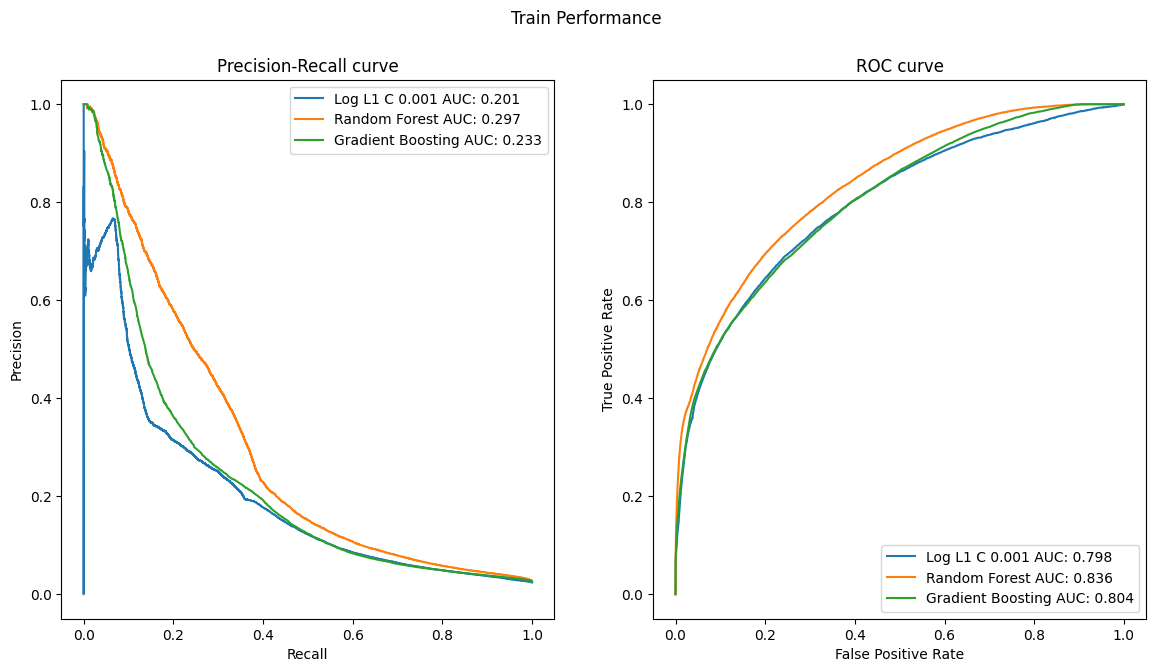

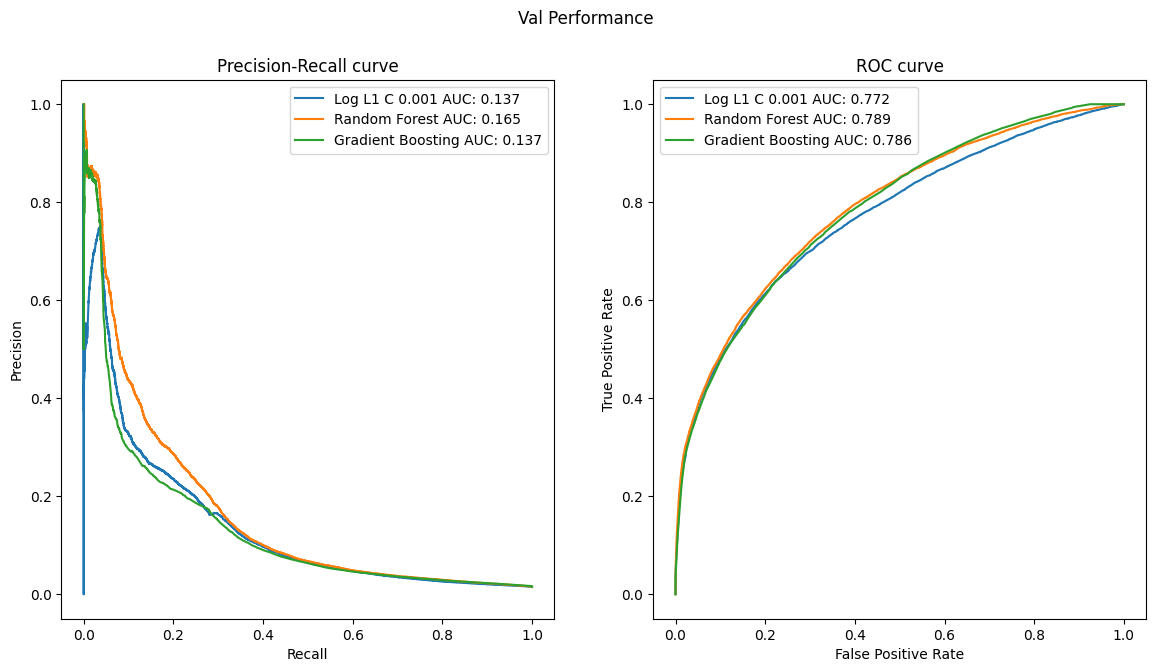

In [35]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Train Performance')
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle('Val Performance')

plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_train)[:,1],Y_train,figure=(fig1,ax1))
plot_roc__pr_curves('Gradient Boosting',gbc_model_reduced.predict_proba(X_train.loc[:,X.columns.isin(new_features_gbc)])[:,1],Y_train,figure=(fig1,ax1))

plot_roc__pr_curves('Log L1 C 0.001',log_l1.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves('Gradient Boosting',gbc_model_reduced.predict_proba(X_val.loc[:,X.columns.isin(new_features_gbc)])[:,1],Y_val,figure=(fig2,ax2))

**Insights:**
- We can see both Random Forest and Gradient Boosting models clearly outperform the Logistic Regression model used as baseline, both in the training and validation set, for the chosen metrics.
- The Random Forest model outperforms the Gradient Boosting model, but the Gradient Boosting model is faster to train and predict.
- Depending on the business needs, we can choose the model that best suits the problem, considering the trade-off between performance and time.

## Threshold Selection

We will chooose the threshold 0.05 for both models, since current push nmoifications have an open rate of 0.05, so we will choose this threshold to maximize the number of users that will receive the push notification.

In [53]:
from sklearn.metrics import confusion_matrix
def metrics_summary(model:Pipeline,model_name:str, X:pd.DataFrame, Y:pd.Series, threshold:float=0.5)->pd.DataFrame:
    """We get the metrics of the model with the threshold given"""
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    
    
    tn, fp, fn, tp = confusion_matrix(Y, preds).ravel()

    
    results = {
        'threshold': [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "tpr": [],
        "fpr": []
    }
    
    results['threshold'] = threshold
    results["accuracy"] = accuracy_score(Y, preds)
    results["precision"] = precision_score(Y, preds, zero_division=0)
    results["recall"] = recall_score(Y, preds)
    results["f1_score"] = f1_score(Y, preds)
    results["tpr"] = results["recall"]
    results["fpr"] = fp / (fp + tn)
    
    return pd.DataFrame(results, index=[model_name])

In [54]:
threshold = 0.05
metrics_rf = metrics_summary(best_rf_model,"RF", X_val, Y_val, threshold=threshold)
metrics_gbc = metrics_summary(gbc_model_reduced,"GBT" , X_val.loc[:,X.columns.isin(new_features_gbc)], Y_val, threshold=threshold)

pd.concat([metrics_rf, metrics_gbc], axis=0)

,threshold,accuracy,precision,recall,f1_score,tpr,fpr
RF,0.05,0.961147,0.147228,0.324876,0.202628,0.324876,0.029036
GBT,0.05,0.964677,0.154519,0.296203,0.203092,0.296203,0.025008


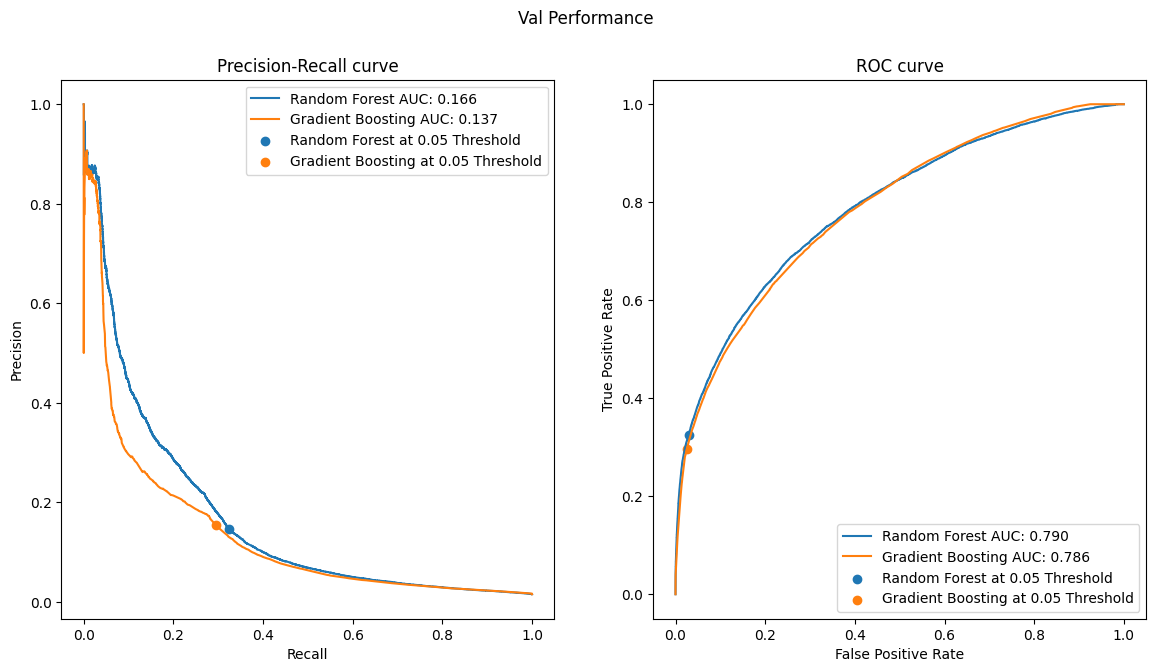

In [57]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle('Val Performance')

plot_roc__pr_curves('Random Forest',best_rf_model.predict_proba(X_val)[:,1],Y_val,figure=(fig1,ax1))
plot_roc__pr_curves('Gradient Boosting',gbc_model_reduced.predict_proba(X_val.loc[:,X.columns.isin(new_features_gbc)])[:,1],Y_val,figure=(fig1,ax1))

ax1[0].scatter(metrics_rf['recall'], metrics_rf['precision'], label='Random Forest at 0.05 Threshold')
ax1[0].scatter(metrics_gbc['recall'], metrics_gbc['precision'], label='Gradient Boosting at 0.05 Threshold') 
ax1[0].legend()

ax1[1].scatter(metrics_rf['fpr'], metrics_rf['tpr'], label='Random Forest at 0.05 Threshold')
ax1[1].scatter(metrics_gbc['fpr'], metrics_gbc['tpr'], label='Gradient Boosting at 0.05 Threshold')
ax1[1].legend()

plt.show()

**Final Insights:**
- Random Forest and Gradient Boosting models, perform better than the Logistic Regression model used as baseline, both in training and validation set.
- Random Forest model performs better with all features, while Gradient Boosting model performs better with reduced features, which can be due to the fact that the reduced model is less prone to overfit and maybe the features we dropped were generating noise and worsing the model capacity to generalize.
- Random Forest model outperforms the Gradient Boosting model, but the Gradient Boosting model is faster to train and predict.
- At 0.05 threshold Random Forest model is better on the Precision-Recall Curve and ROC Curve.
- Depending on the business needs, we can choose the model that best suits the problem, considering the trade-off between performance and time.
- In this case we will choose the Random Forest model with all features, since it performs better and the time-performance trade-off is not significant.